# 📙 qb-database 

In [1]:
import sys
import pandas as pd
import datetime as dt
import pytz
import psycopg2
from psycopg2 import sql
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.rcParams["font.family"] = "Tahoma"
plt.rcParams["font.size"] = 8
plt.rcParams["axes.axisbelow"] = True
from db import *
from vendors import *

Yahoo: ONLINE


### inputs

In [2]:
table = "symbols_macro"
symbols = getattr(sys.modules[__name__], table)
interval = "5m"
limit = 1000

### create table

In [3]:
# connect to the database
host = "localhost"
database = "qbdb"
user = "postgres"
password = "password"
conn = psycopg2.connect(host=host, database=database, user=user, password=password)
cursor = conn.cursor()

try:
    # create symbols table
    query = sql.SQL(
            """
            CREATE TABLE {table} ("ID" SERIAL PRIMARY KEY, "GROUP" TEXT NOT NULL, "NAME" TEXT NOT NULL, "SYMBOL" TEXT NOT NULL, "EXCHANGE" TEXT NOT NULL, "PLATFORM" TEXT NOT NULL, "BROKER" TEXT NOT NULL, "CCY" TEXT NOT NULL,"TIMEZONE" TEXT NOT NULL, "TRADE_STARTS" TIME NOT NULL, "TRADE_ENDS" TIME NOT NULL)
            """).format(table=sql.Identifier(table))
    cursor.execute(query)

    # create ohlc hypertable
    query = sql.SQL(
            """
            CREATE TABLE {table_symbols_ohlc} ("ID_SYMBOL" INTEGER NOT NULL, "DATETIME" TIMESTAMP WITHOUT TIME ZONE NOT NULL, "OPEN" NUMERIC NOT NULL, "HIGH" NUMERIC NOT NULL, "LOW" NUMERIC NOT NULL, "CLOSE" NUMERIC NOT NULL, "VOLUME" BIGINT NOT NULL,
            CONSTRAINT {fkey} FOREIGN KEY ("ID_SYMBOL") REFERENCES {table} ("ID") ON DELETE CASCADE,
            PRIMARY KEY ("ID_SYMBOL", "DATETIME"))
            """).format(table_symbols_ohlc=sql.Identifier(f"{table}_ohlc"), fkey=sql.Identifier(f"{table}_ohlc_id_symbol_fkey"), table=sql.Identifier(table))
    cursor.execute(query)
    query = sql.SQL(
            """
            SELECT create_hypertable('{table_ohlc}', by_range('DATETIME'))
            """).format(table_ohlc=sql.Identifier(f"{table}_ohlc"))
    cursor.execute(query)
    
    # populate symbols table
    for symbol in symbols:
        query = sql.SQL(
                """
                SELECT *
                FROM {table} 
                WHERE "ID" = %s
                LIMIT 1
                """).format(table=sql.Identifier(table))
        cursor.execute(query, [symbol["ID"]])
        if not cursor.fetchall():
            query = sql.SQL(
                    """
                    INSERT INTO {table} ("ID", "GROUP", "NAME", "SYMBOL", "EXCHANGE", "PLATFORM", "BROKER", "CCY", "TIMEZONE", "TRADE_STARTS", "TRADE_ENDS")
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                    """).format(table=sql.Identifier(table))
            cursor.execute(query, list(symbol.values()))
            print(f"{table} -> Added symbol: {symbol["NAME"]} ({symbol["SYMBOL"]})")

    # populate ohlc hypertable
    for symbol in symbols:
        query = sql.SQL(
                """
                SELECT *
                FROM {table_ohlc} 
                WHERE "ID_SYMBOL" = %s
                ORDER BY "DATETIME" DESC
                LIMIT 1
                """).format(table_ohlc=sql.Identifier(f"{table}_ohlc"))
        cursor.execute(query, [symbol["ID"]])
        
        if not cursor.fetchall():
            # set time range
            start = dt.datetime(2024, 10, 1, 0, 0, 0, tzinfo=pytz.timezone(symbol["TIMEZONE"]))
            final = dt.datetime.now(pytz.timezone(symbol["TIMEZONE"])).replace(second=0, microsecond=0, tzinfo=None)
        
            # fetch data from vendor
            df = getattr(sys.modules[__name__], symbol["PLATFORM"]).Download(symbol["SYMBOL"], symbol["TIMEZONE"], start, final)

            if not df.empty:
                # final formatting
                df = df[(symbol["TRADE_STARTS"] <= df["DATETIME"].dt.time) & (df["DATETIME"].dt.time < symbol["TRADE_ENDS"])]
                df.insert(0, "ID_SYMBOL", symbol["ID"])
                df = df[["ID_SYMBOL", "DATETIME", "OPEN", "HIGH", "LOW", "CLOSE", "VOLUME"]]
            
                # check integrity
                print(f"{table} -> Fetched {len(df)} new bars for symbol: {symbol["NAME"]} ({symbol["SYMBOL"]}) | First: {df["DATETIME"].iloc[0]} | Last: {df["DATETIME"].iloc[-1]}")
                
                # insert new rows into the database
                for row in list(df.itertuples(index=False, name=None)):
                    query = sql.SQL(
                            """
                            INSERT INTO {table_ohlc} ("ID_SYMBOL", "DATETIME", "OPEN", "HIGH", "LOW", "CLOSE", "VOLUME")
                            VALUES (%s, %s, %s, %s, %s, %s, %s)
                            ON CONFLICT ("ID_SYMBOL", "DATETIME") DO UPDATE
                            SET "OPEN" = EXCLUDED."OPEN", "HIGH" = EXCLUDED."HIGH", "LOW" = EXCLUDED."LOW", "CLOSE" = EXCLUDED."CLOSE", "VOLUME" = EXCLUDED."VOLUME"
                            """).format(table_ohlc=sql.Identifier(f"{table}_ohlc"))
                    cursor.execute(query, row)
            else:
                print(f"{table} -> \u001b[41;1mError:\033[0m No data fetched for symbol: {symbol["NAME"]} ({symbol["SYMBOL"]})")
    
    # commit to database
    conn.commit()

except (Exception, psycopg2.Error) as error:
    print(f"Error: {error}")

# close database connection
conn.close()

symbols_macro -> Added symbol: S&P 500 (^GSPC)
symbols_macro -> Added symbol: Dow 30 (^DJI)
symbols_macro -> Added symbol: Nasdaq 100 (^NDX)
symbols_macro -> Added symbol: Russell 2000 (^RUT)
symbols_macro -> Added symbol: VIX (^VIX)
symbols_macro -> Added symbol: FTSE 100 (^FTSE)
symbols_macro -> Added symbol: Euronext 100 (^N100)
symbols_macro -> Added symbol: DAX 40 (^GDAXI)
symbols_macro -> Added symbol: CAC 40 (^FCHI)
symbols_macro -> Added symbol: Nikkei 225 (^N225)
symbols_macro -> Added symbol: SSE Composite (000001.SS)
symbols_macro -> Added symbol: Ibovespa (^BVSP)
symbols_macro -> Added symbol: Bitcoin (BTC-USD)
symbols_macro -> Added symbol: Gold (GC=F)
symbols_macro -> Added symbol: Silver (SI=F)
symbols_macro -> Added symbol: Crude Oil (CL=F)
symbols_macro -> Added symbol: Natural Gas (NG=F)
symbols_macro -> Added symbol: Coffee (KC=F)
symbols_macro -> Added symbol: Sugar (SB=F)
symbols_macro -> Added symbol: Cocoa (CC=F)
symbols_macro -> Added symbol: Soybean (ZL=F)
symb

[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 2891 new bars for symbol: S&P 500 (^GSPC) | First: 2024-10-01 09:30:00 | Last: 2024-11-21 09:50:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 2891 new bars for symbol: Dow 30 (^DJI) | First: 2024-10-01 09:30:00 | Last: 2024-11-21 09:50:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 2891 new bars for symbol: Nasdaq 100 (^NDX) | First: 2024-10-01 09:30:00 | Last: 2024-11-21 09:50:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 2888 new bars for symbol: Russell 2000 (^RUT) | First: 2024-10-01 09:30:00 | Last: 2024-11-21 09:35:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 5848 new bars for symbol: VIX (^VIX) | First: 2024-10-01 02:15:00 | Last: 2024-11-21 08:35:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 3854 new bars for symbol: FTSE 100 (^FTSE) | First: 2024-10-01 08:00:00 | Last: 2024-11-21 14:35:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 3853 new bars for symbol: Euronext 100 (^N100) | First: 2024-10-01 09:00:00 | Last: 2024-11-21 15:35:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 3855 new bars for symbol: DAX 40 (^GDAXI) | First: 2024-10-01 09:00:00 | Last: 2024-11-21 15:35:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 3852 new bars for symbol: CAC 40 (^FCHI) | First: 2024-10-01 09:00:00 | Last: 2024-11-21 15:35:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 2232 new bars for symbol: Nikkei 225 (^N225) | First: 2024-10-01 09:00:00 | Last: 2024-11-21 14:55:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 1617 new bars for symbol: SSE Composite (000001.SS) | First: 2024-10-08 09:30:00 | Last: 2024-11-21 14:55:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 2958 new bars for symbol: Ibovespa (^BVSP) | First: 2024-10-01 10:00:00 | Last: 2024-11-21 11:35:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 14862 new bars for symbol: Bitcoin (BTC-USD) | First: 2024-10-01 00:00:00 | Last: 2024-11-21 14:50:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 10289 new bars for symbol: Gold (GC=F) | First: 2024-10-01 00:55:00 | Last: 2024-11-21 09:40:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 10284 new bars for symbol: Silver (SI=F) | First: 2024-10-01 00:55:00 | Last: 2024-11-21 09:40:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 9658 new bars for symbol: Crude Oil (CL=F) | First: 2024-10-01 00:55:00 | Last: 2024-11-21 09:40:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 9903 new bars for symbol: Natural Gas (NG=F) | First: 2024-10-01 00:55:00 | Last: 2024-11-21 09:40:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 4095 new bars for symbol: Coffee (KC=F) | First: 2024-10-01 04:15:00 | Last: 2024-11-21 09:30:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 4214 new bars for symbol: Sugar (SB=F) | First: 2024-10-01 03:30:00 | Last: 2024-11-21 09:30:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 3859 new bars for symbol: Cocoa (CC=F) | First: 2024-10-01 04:45:00 | Last: 2024-11-21 09:30:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 7846 new bars for symbol: Soybean (ZL=F) | First: 2024-10-01 00:55:00 | Last: 2024-11-21 09:40:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 7694 new bars for symbol: Corn (ZC=F) | First: 2024-10-01 00:55:00 | Last: 2024-11-21 09:40:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 7090 new bars for symbol: Cotton (CT=F) | First: 2024-10-01 00:55:00 | Last: 2024-11-21 09:30:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 7773 new bars for symbol: Wheat (ZW=F) | First: 2024-10-01 00:55:00 | Last: 2024-11-21 09:40:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 4435 new bars for symbol: USD/BRL (BRL=X) | First: 2024-10-01 03:00:00 | Last: 2024-11-21 14:50:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 10673 new bars for symbol: EUR/USD (EURUSD=X) | First: 2024-10-01 00:00:00 | Last: 2024-11-21 14:50:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 10634 new bars for symbol: USD/JPY (JPY=X) | First: 2024-10-01 00:00:00 | Last: 2024-11-21 14:50:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 10673 new bars for symbol: GBP/USD (GBPUSD=X) | First: 2024-10-01 00:00:00 | Last: 2024-11-21 14:50:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 10653 new bars for symbol: USD/CAD (CAD=X) | First: 2024-10-01 00:00:00 | Last: 2024-11-21 14:50:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 10679 new bars for symbol: USD/AUD (AUD=X) | First: 2024-10-01 00:00:00 | Last: 2024-11-21 14:50:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 10641 new bars for symbol: USD/NZD (NZD=X) | First: 2024-10-01 00:00:00 | Last: 2024-11-21 14:50:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 4450 new bars for symbol: USD/CNY (CNY=X) | First: 2024-10-01 03:00:00 | Last: 2024-11-21 14:50:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 2130 new bars for symbol: USD/RUB (RUB=X) | First: 2024-10-01 01:35:00 | Last: 2024-11-21 14:35:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 2977 new bars for symbol: US Treasury 13-Week (^IRX) | First: 2024-10-01 07:20:00 | Last: 2024-11-21 08:40:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 2977 new bars for symbol: US Treasury 5-Year (^FVX) | First: 2024-10-01 07:20:00 | Last: 2024-11-21 08:40:00


[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 2977 new bars for symbol: US Treasury 10-Year (^TNX) | First: 2024-10-01 07:20:00 | Last: 2024-11-21 08:40:00


### update table

In [4]:
# connect to the database
host = "localhost"
database = "qbdb"
user = "postgres"
password = "password"
conn = psycopg2.connect(host=host, database=database, user=user, password=password)
cursor = conn.cursor()

try:
    for symbol in symbols:
        query = sql.SQL(
                """
                SELECT *
                FROM {table_ohlc} 
                WHERE "ID_SYMBOL" = %s
                ORDER BY "DATETIME" DESC
                LIMIT 1
                """).format(table_ohlc=sql.Identifier(f"{table}_ohlc"))
        cursor.execute(query, [symbol["ID"]])
        
        # set time range
        start = cursor.fetchall()[0][1]
        final = dt.datetime.now(pytz.timezone(symbol["TIMEZONE"])).replace(second=0, microsecond=0, tzinfo=None)
    
        # fetch data from vendor
        df = getattr(sys.modules[__name__], symbol["PLATFORM"]).Download(symbol["SYMBOL"], symbol["TIMEZONE"], start, final)

        if not df.empty:
            # final formatting
            df = df[(symbol["TRADE_STARTS"] <= df["DATETIME"].dt.time) & (df["DATETIME"].dt.time < symbol["TRADE_ENDS"])]
            df.insert(0, "ID_SYMBOL", symbol["ID"])
            df = df[["ID_SYMBOL", "DATETIME", "OPEN", "HIGH", "LOW", "CLOSE", "VOLUME"]]
        
            # check integrity
            print(f"{table} -> Fetched {len(df)} new bars for symbol: {symbol["NAME"]} ({symbol["SYMBOL"]}) | First: {df["DATETIME"].iloc[0]} | Last: {df["DATETIME"].iloc[-1]}")
            
            # insert new rows into the database
            for row in list(df.itertuples(index=False, name=None)):
                query = sql.SQL(
                        """
                        INSERT INTO {table_ohlc} ("ID_SYMBOL", "DATETIME", "OPEN", "HIGH", "LOW", "CLOSE", "VOLUME")
                        VALUES (%s, %s, %s, %s, %s, %s, %s)
                        ON CONFLICT ("ID_SYMBOL", "DATETIME") DO UPDATE
                        SET "OPEN" = EXCLUDED."OPEN", "HIGH" = EXCLUDED."HIGH", "LOW" = EXCLUDED."LOW", "CLOSE" = EXCLUDED."CLOSE", "VOLUME" = EXCLUDED."VOLUME"
                        """).format(table_ohlc=sql.Identifier(f"{table}_ohlc"))
                cursor.execute(query, row)
        else:
            print(f"{table} -> \u001b[41;1mError:\033[0m No data fetched for symbol: {symbol["NAME"]} ({symbol["SYMBOL"]})")
    
    # commit to database
    conn.commit()

except (Exception, psycopg2.Error) as error:
    print(f"Error: {error}")

# close database connection
conn.close()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 2 new bars for symbol: S&P 500 (^GSPC) | First: 2024-11-21 09:50:00 | Last: 2024-11-21 09:55:00
symbols_macro -> Fetched 2 new bars for symbol: Dow 30 (^DJI) | First: 2024-11-21 09:50:00 | Last: 2024-11-21 09:55:00
symbols_macro -> Fetched 2 new bars for symbol: Nasdaq 100 (^NDX) | First: 2024-11-21 09:50:00 | Last: 2024-11-21 09:55:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

symbols_macro -> Fetched 2 new bars for symbol: Russell 2000 (^RUT) | First: 2024-11-21 09:35:00 | Last: 2024-11-21 09:40:00
symbols_macro -> Fetched 2 new bars for symbol: VIX (^VIX) | First: 2024-11-21 08:35:00 | Last: 2024-11-21 08:40:00
symbols_macro -> Fetched 2 new bars for symbol: FTSE 100 (^FTSE) | First: 2024-11-21 14:35:00 | Last: 2024-11-21 14:40:00



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 2 new bars for symbol: Euronext 100 (^N100) | First: 2024-11-21 15:35:00 | Last: 2024-11-21 15:40:00
symbols_macro -> Fetched 2 new bars for symbol: DAX 40 (^GDAXI) | First: 2024-11-21 15:35:00 | Last: 2024-11-21 15:40:00
symbols_macro -> Fetched 2 new bars for symbol: CAC 40 (^FCHI) | First: 2024-11-21 15:35:00 | Last: 2024-11-21 15:40:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 1 new bars for symbol: Nikkei 225 (^N225) | First: 2024-11-21 14:55:00 | Last: 2024-11-21 14:55:00
symbols_macro -> Fetched 1 new bars for symbol: SSE Composite (000001.SS) | First: 2024-11-21 14:55:00 | Last: 2024-11-21 14:55:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

symbols_macro -> Fetched 2 new bars for symbol: Ibovespa (^BVSP) | First: 2024-11-21 11:35:00 | Last: 2024-11-21 11:40:00
symbols_macro -> Fetched 1 new bars for symbol: Bitcoin (BTC-USD) | First: 2024-11-21 14:50:00 | Last: 2024-11-21 14:50:00
symbols_macro -> Fetched 2 new bars for symbol: Gold (GC=F) | First: 2024-11-21 09:40:00 | Last: 2024-11-21 09:45:00



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

symbols_macro -> Fetched 2 new bars for symbol: Silver (SI=F) | First: 2024-11-21 09:40:00 | Last: 2024-11-21 09:45:00
symbols_macro -> Fetched 2 new bars for symbol: Crude Oil (CL=F) | First: 2024-11-21 09:40:00 | Last: 2024-11-21 09:45:00



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

symbols_macro -> Fetched 2 new bars for symbol: Natural Gas (NG=F) | First: 2024-11-21 09:40:00 | Last: 2024-11-21 09:45:00
symbols_macro -> Fetched 2 new bars for symbol: Coffee (KC=F) | First: 2024-11-21 09:30:00 | Last: 2024-11-21 09:35:00
symbols_macro -> Fetched 2 new bars for symbol: Sugar (SB=F) | First: 2024-11-21 09:30:00 | Last: 2024-11-21 09:35:00



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 2 new bars for symbol: Cocoa (CC=F) | First: 2024-11-21 09:30:00 | Last: 2024-11-21 09:35:00
symbols_macro -> Fetched 2 new bars for symbol: Soybean (ZL=F) | First: 2024-11-21 09:40:00 | Last: 2024-11-21 09:45:00
symbols_macro -> Fetched 2 new bars for symbol: Corn (ZC=F) | First: 2024-11-21 09:40:00 | Last: 2024-11-21 09:45:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 2 new bars for symbol: Cotton (CT=F) | First: 2024-11-21 09:30:00 | Last: 2024-11-21 09:35:00
symbols_macro -> Fetched 2 new bars for symbol: Wheat (ZW=F) | First: 2024-11-21 09:40:00 | Last: 2024-11-21 09:45:00
symbols_macro -> Fetched 2 new bars for symbol: USD/BRL (BRL=X) | First: 2024-11-21 14:50:00 | Last: 2024-11-21 14:55:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 2 new bars for symbol: EUR/USD (EURUSD=X) | First: 2024-11-21 14:50:00 | Last: 2024-11-21 14:55:00
symbols_macro -> Fetched 2 new bars for symbol: USD/JPY (JPY=X) | First: 2024-11-21 14:50:00 | Last: 2024-11-21 14:55:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


symbols_macro -> Fetched 2 new bars for symbol: GBP/USD (GBPUSD=X) | First: 2024-11-21 14:50:00 | Last: 2024-11-21 14:55:00
symbols_macro -> Fetched 2 new bars for symbol: USD/CAD (CAD=X) | First: 2024-11-21 14:50:00 | Last: 2024-11-21 14:55:00
symbols_macro -> Fetched 2 new bars for symbol: USD/AUD (AUD=X) | First: 2024-11-21 14:50:00 | Last: 2024-11-21 14:55:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CNY=X']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (5m 2024-11-21 14:50:00 -> 2024-11-21 14:56:00)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RUB=X']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (5m 2024-11-21 14:35:00 -> 2024-11-21 14:56:00)')


symbols_macro -> Fetched 2 new bars for symbol: USD/NZD (NZD=X) | First: 2024-11-21 14:50:00 | Last: 2024-11-21 14:55:00
symbols_macro -> Error: No data fetched for symbol: USD/CNY (CNY=X)
symbols_macro -> Error: No data fetched for symbol: USD/RUB (RUB=X)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

symbols_macro -> Fetched 1 new bars for symbol: US Treasury 13-Week (^IRX) | First: 2024-11-21 08:40:00 | Last: 2024-11-21 08:40:00
symbols_macro -> Fetched 1 new bars for symbol: US Treasury 5-Year (^FVX) | First: 2024-11-21 08:40:00 | Last: 2024-11-21 08:40:00
symbols_macro -> Fetched 1 new bars for symbol: US Treasury 10-Year (^TNX) | First: 2024-11-21 08:40:00 | Last: 2024-11-21 08:40:00


### plot

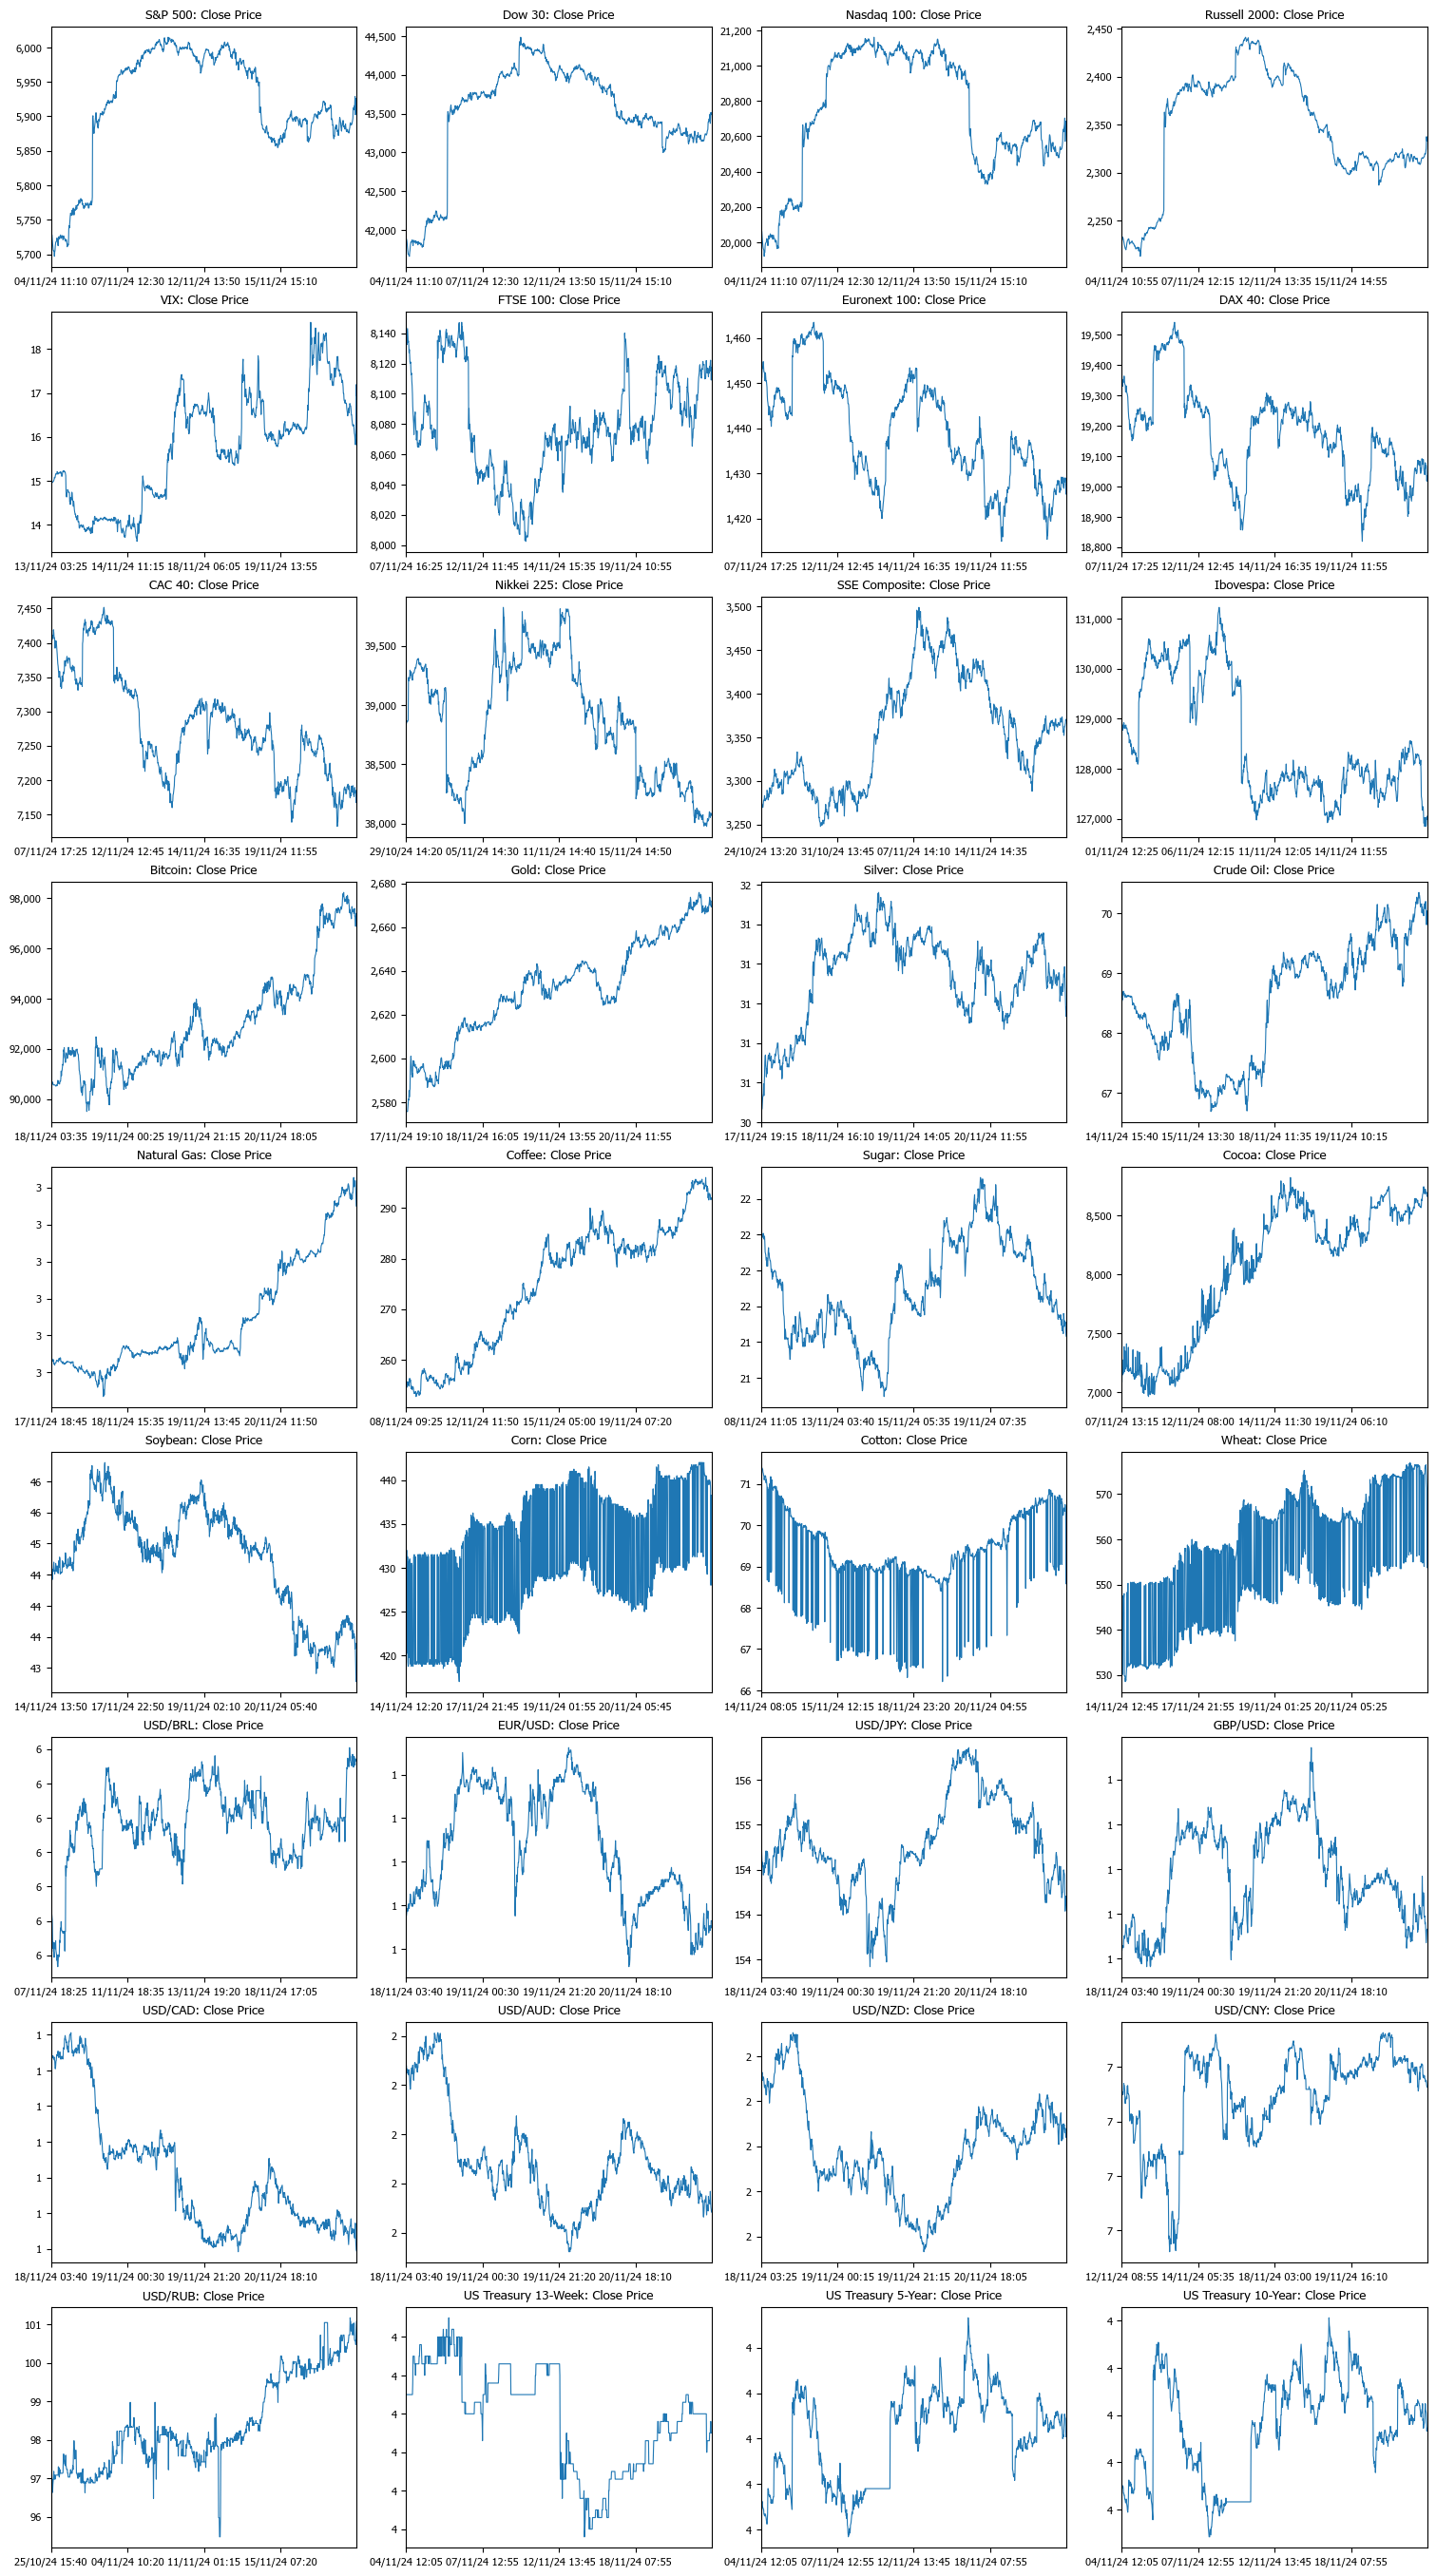

In [6]:
# connect to the database
host = "localhost"
database = "qbdb"
user = "postgres"
password = "password"
conn = psycopg2.connect(host=host, database=database, user=user, password=password)
cursor = conn.cursor()

# plot close price for each symbol
interval_str = {"15m": "15 minutes", "30m": "30 minutes", "1h": "1 hour", "1d": "1 day"}
rows_count = int(len(symbols) / 4 + 1 * (len(symbols) % 4))
fig = plt.figure(figsize=(15, 3 * rows_count), constrained_layout=True)

try:
    for idx, symbol in enumerate(symbols):
        # query ohlc hypertable
        if interval == "5m":
            query = sql.SQL(
                    """
                    SELECT "DATETIME", "OPEN", "HIGH", "LOW", "CLOSE", "VOLUME"
                    FROM {table_ohlc} 
                    WHERE "ID_SYMBOL" = %s
                    ORDER BY "DATETIME" DESC
                    LIMIT %s
                    """).format(table_ohlc=sql.Identifier(f"{table}_ohlc"))
            cursor.execute(query, [symbol["ID"], limit])
        # query aggregated ohlc hypertable
        else:
            query = sql.SQL(
                    """
                    SELECT time_bucket(%s, "DATETIME") AS AGG_DATETIME, FIRST("OPEN", "DATETIME"), MAX("HIGH"), MIN("LOW"), LAST("CLOSE", "DATETIME"), SUM("VOLUME")
                    FROM {table_ohlc} WHERE "ID_SYMBOL" = %s
                    GROUP BY AGG_DATETIME, "ID_SYMBOL"
                    ORDER BY AGG_DATETIME DESC
                    LIMIT %s
                    """).format(table_ohlc=sql.Identifier(f"{table}_ohlc"))
            cursor.execute(query, [interval_str[interval], symbol["ID"], limit])
    
        df = pd.DataFrame(cursor.fetchall(), columns=["DATETIME", "OPEN", "HIGH", "LOW", "CLOSE", "VOLUME"])[::-1]
        df.set_index("DATETIME", inplace=True)
    
        if not df.empty:
            ax = fig.add_subplot(rows_count, 4, idx + 1)
            ax.set_title(f"{symbol["NAME"]}: Close Price")
            ax.plot(df.index.strftime("%d/%m/%y %H:%M"), df["CLOSE"], linewidth=0.8)
            ax.xaxis.set_major_locator(mticker.MaxNLocator(min(4, len(df.index))))
            
            yticks_loc = ax.get_yticks().tolist()
            ax.yaxis.set_major_locator(mticker.FixedLocator(yticks_loc))
            ax.set_yticklabels(["{:,.0f}".format(x) for x in yticks_loc])
            ax.margins(x=0)

except (Exception, psycopg2.Error) as error:
    print(f"Error: {error}")

# close database connection
conn.close()